In [8]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
import os

In [44]:
f = h5pyd.File("/nrel/nsrdb/meteosat/meteosat_2019.h5", 'r')

In [58]:
list(f)  # list the datasets in the file

['coordinates',
 'meta',
 'ozone',
 'solar_zenith_angle',
 'surface_albedo',
 'time_index',
 'total_precipitable_water',
 'alpha',
 'aod',
 'asymmetry',
 'ssa',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'cloud_fill_flag',
 'cloud_type',
 'dew_point',
 'relative_humidity',
 'surface_pressure',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'air_temperature',
 'wind_direction',
 'wind_speed']

In [59]:
dset = f['ghi']
dset.shape

(35040, 3869544)

In [18]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index 

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:15:00',
               '2018-01-01 00:30:00', '2018-01-01 00:45:00',
               '2018-01-01 01:00:00', '2018-01-01 01:15:00',
               '2018-01-01 01:30:00', '2018-01-01 01:45:00',
               '2018-01-01 02:00:00', '2018-01-01 02:15:00',
               ...
               '2018-12-31 21:30:00', '2018-12-31 21:45:00',
               '2018-12-31 22:00:00', '2018-12-31 22:15:00',
               '2018-12-31 22:30:00', '2018-12-31 22:45:00',
               '2018-12-31 23:00:00', '2018-12-31 23:15:00',
               '2018-12-31 23:30:00', '2018-12-31 23:45:00'],
              dtype='datetime64[ns]', length=35040, freq=None)

In [20]:
import pandas as pd
meta = pd.DataFrame(f['meta'][...])
meta.dtypes

latitude     float32
longitude    float32
elevation      int16
timezone       int16
country       object
state         object
county        object
dtype: object

In [21]:
# Convert byte strings in the 'country' column to regular strings
meta['country'] = meta['country'].apply(lambda x: x.decode('utf-8'))

# Get unique country names
unique_countries = meta['country'].unique()

# To display the unique countries, you can convert it to a list
unique_country_list = list(unique_countries)
print(unique_country_list)

['None', 'Cape Verde', 'Spain', 'Senegal', 'Portugal', 'Western Sahara', 'Mauritania', 'Gambia', 'Guinea-Bissau', 'Guinea', 'Saint Helena', 'Sierra Leone', 'Morocco', 'Mali', 'Liberia', 'Algeria', 'Ireland', "Côte d'Ivoire", 'United Kingdom', 'Burkina Faso', 'France', 'Isle of Man', 'Ghana', 'Guernsey', 'Jersey', 'Togo', 'Niger', 'Benin', 'Andorra', 'Belgium', 'Nigeria', 'Bouvet Island', 'Netherlands', 'Norway', 'Luxembourg', 'Germany', 'Switzerland', 'São Tomé and Príncipe', 'Italy', 'Monaco', 'Tunisia', 'Denmark', 'Equatorial Guinea', 'Cameroon', 'Gabon', 'Libya', 'Liechtenstein', 'Austria', 'Sweden', 'Republic of Congo', 'Angola', 'Namibia', 'Czech Republic', 'Democratic Republic of the Congo', 'San Marino', 'Slovenia', 'Croatia', 'Chad', 'Poland', 'Malta', 'Central African Republic', 'Bosnia and Herzegovina', 'Hungary', 'South Africa', 'Slovakia', 'Montenegro', 'Serbia', 'Albania', 'Greece', 'Russia', 'Kosovo', 'Botswana', 'Åland', 'Romania', 'Macedonia', 'Latvia', 'Lithuania', 'Fi

In [51]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 271 GB per dataset

271.17764352

In [52]:
dset.chunks

(1344, 744)

In [53]:
INDO = meta.loc[meta['country'] == 'India'] 
INDO.head()

,latitude,longitude,elevation,timezone,country,state,county
2949865,23.850000,68.220001,2,5,India,b'Gujarat',b'Kachchh'
2949866,23.809999,68.220001,3,5,India,b'Gujarat',b'Kachchh'
2949867,23.770000,68.220001,2,5,India,b'Gujarat',b'Kachchh'
2949868,23.730000,68.220001,2,5,India,b'Gujarat',b'Kachchh'
2949871,23.610001,68.220001,2,5,India,b'Gujarat',b'Kachchh'


In [54]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:15:00',
               '2018-01-01 00:30:00', '2018-01-01 00:45:00',
               '2018-01-01 01:00:00', '2018-01-01 01:15:00',
               '2018-01-01 01:30:00', '2018-01-01 01:45:00',
               '2018-01-01 02:00:00', '2018-01-01 02:15:00',
               ...
               '2018-12-31 21:30:00', '2018-12-31 21:45:00',
               '2018-12-31 22:00:00', '2018-12-31 22:15:00',
               '2018-12-31 22:30:00', '2018-12-31 22:45:00',
               '2018-12-31 23:00:00', '2018-12-31 23:15:00',
               '2018-12-31 23:30:00', '2018-12-31 23:45:00'],
              dtype='datetime64[ns]', length=35040, freq=None)

In [55]:
timestep = np.where(time_index == '2019-12-31 12:00:00')[0][0]
timestep

34944

In [56]:
%time data = dset[timestep][INDO.index]  # full-resolution subset
df = INDO[['longitude', 'latitude']].copy()
df['ghi'] = data
df.shape

CPU times: user 157 ms, sys: 106 ms, total: 263 ms
Wall time: 42.6 s


(174190, 3)

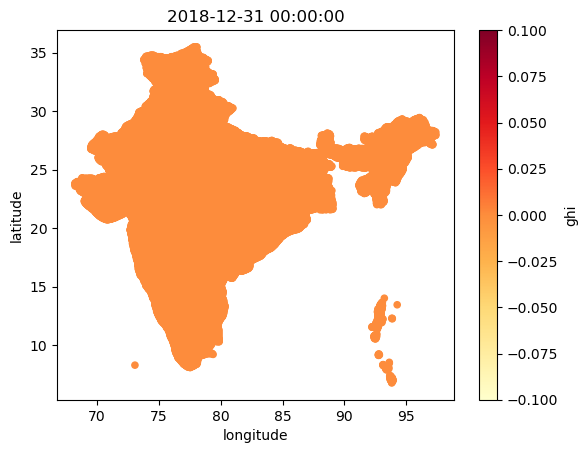

In [57]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [15]:
def plot_ghi_at_time(country_meta, time_index, dset, specific_time, output_folder, country):
    # Find the index for the specific time
    timestep = np.where(time_index == specific_time)[0][0]
    
    # Extract GHI data for the specific time
    ghi_data = dset[timestep][country_meta.index]

    # Generate and save plot
    plt.figure()
    plt.scatter(country_meta['longitude'], country_meta['latitude'], c=ghi_data, cmap='YlOrRd')
    plt.colorbar(label='GHI')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GHI for {country} at {specific_time}')
    plt.savefig(f'{output_folder}{country}_ghi_{specific_time}.png')
    plt.close()


In [10]:
    # Open HDF5 file
    f = h5pyd.File("/nrel/nsrdb/meteosat/meteosat_2019.h5", 'r')
    dset = f['ghi']
    meta = pd.DataFrame(f['meta'][...])
    meta['country'] = meta['country'].apply(lambda x: x.decode('utf-8'))

    # Efficiently load time_index
    time_index = pd.to_datetime(f['time_index'][...].astype(str))

    # Save time_index
    output_folder = 'output/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    time_index_df = pd.DataFrame(time_index, columns=['time'])
    time_index_df.to_csv(f'{output_folder}time_index.csv', index=False)

In [16]:
    # Specific time for GHI data
    specific_time = '2019-12-31 12:00:00'
      # Process countries
    countries = ['India', 'Indonesia', 'China', 'South Africa']
    for country in countries:
        country_meta = meta.loc[meta['country'] == f'{country}']
        
        # Plot GHI data for the specific time
        plot_ghi_at_time(country_meta, time_index, dset, specific_time, output_folder, country)

    print("CSVs and PNG maps created successfully.")

CSVs and PNG maps created successfully.
